## Evaluation of Attack

In [1]:
import torch
import torchvision.transforms as T
import os

from PIL import Image
from facenet_pytorch import InceptionResnetV1
from torch.utils.data import DataLoader, Dataset

from defences import Randomization, BitDepthReduction, Jpeg_compression
from live_reface_attack import UNetAttackGenerator


c:\Users\pierc\miniconda3\envs\tinyml-facedet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class FaceAttackDataset(Dataset):
    def __init__(self, root_dir, source_idx, target_idx, transform=None):
        """
        Args:
            root_dir (string): Directory with images.
            source_idx (int): Source class index to attack.
            target_idx (int): Target class index to fool the model into predicting.
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.source_idx = source_idx
        self.target_idx = target_idx
        self.samples = []
        self.class_to_idx = {}

        # Get directory list
        subdirs = sorted(os.listdir(root_dir))

        # Create class to index mapping
        for i, sd in enumerate(subdirs):
            self.class_to_idx[sd] = i

        # Get only samples from source class
        for sd in self.class_to_idx.keys():
            label = self.class_to_idx[sd]
            if label != source_idx:
                continue  # Only include source class

            sd_path = os.path.join(root_dir, sd)
            if not os.path.isdir(sd_path):
                continue

            for fname in os.listdir(sd_path):
                fpath = os.path.join(sd_path, fname)
                if os.path.isfile(fpath):
                    self.samples.append((fpath, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fpath, label = self.samples[idx]
        img = Image.open(fpath).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label, self.target_idx

In [ ]:
# Function to evaluate an attack model
def evaluate_attack(source_person, target_person, epsilon=0.05):
    """
    Evaluates a trained attack model on validation images.
    
    Args:
        source_person (str): Name of the person to attack.
        target_person (str): Name of the person to impersonate.
        epsilon (float): Maximum perturbation magnitude.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data transforms - same as training
    transform = T.Compose([
        T.Resize((160, 160)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Load class mapping
    class_labels = ["Al", "Nhat", "Pierce", "Yaqi"]
    source_idx = class_labels.index(source_person)
    target_idx = class_labels.index(target_person)

    print(f"Evaluating attack: {source_person}({source_idx}) → {target_person}({target_idx})")

    # Create dataset focused on source person
    test_dir = 'data/test'  # Use validation images
    dataset = FaceAttackDataset(
        root_dir=test_dir, 
        source_idx=source_idx,
        target_idx=target_idx,
        transform=transform
    )

    if len(dataset) == 0:
        print(f"Error: No samples found for person {source_person}")
        return False

    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

    # Load the victim face recognition model
    face_model = InceptionResnetV1(
        classify=True,
        pretrained=None,
        num_classes=len(class_labels)
    ).to(device)
    
    face_model.load_state_dict(torch.load("facenet_4class.pth", map_location=device))
    face_model.eval()  # Set to evaluation mode

    # Load trained attack model
    attack_model = UNetAttackGenerator().to(device)
    attack_model.load_state_dict(torch.load(f"attack_{source_person}_to_{target_person}.pth", map_location=device))
    attack_model.eval()

    # Evaluation loop
    total_samples = 0
    attack_success = 0

    with torch.no_grad():
        for images, orig_labels, target_labels in dataloader:
            images = images.to(device)
            orig_labels = orig_labels.to(device)
            target_labels = target_labels.to(device)

            # Generate perturbation and adversarial images
            perturbation = attack_model(images)
            adv_images = torch.clamp(images + perturbation, -1, 1)

            # Get predictions
            clean_outputs = face_model(images)
            adv_outputs = face_model(adv_images)

            clean_preds = torch.argmax(clean_outputs, dim=1)
            adv_preds = torch.argmax(adv_outputs, dim=1)

            # Compute attack success
            success = (adv_preds == target_labels).float().sum().item()
            attack_success += success
            total_samples += images.size(0)

    success_rate = attack_success / total_samples * 100
    print(f"Attack Success Rate: {success_rate:.2f}%")

    return success_rate

In [5]:
class_labels = ["Al", "Nhat", "Pierce", "Yaqi"]
attack_pairs = [(src, tgt) for src in class_labels for tgt in class_labels if src != tgt]

results = {}

for source_person, target_person in attack_pairs:
    print(f"\n{'='*60}")
    print(f"Evaluating attack: {source_person} → {target_person}")
    print(f"{'='*60}")
    
    success_rate = evaluate_attack(source_person, target_person)
    results[f"{source_person} → {target_person}"] = success_rate

print("\nFinal Results:")
for attack, success_rate in results.items():
    print(f"{attack}: {success_rate:.2f}%")


Evaluating attack: Al → Nhat
Using device: cuda
Evaluating attack: Al(0) → Nhat(1)
Attack Success Rate: 100.00%

Evaluating attack: Al → Pierce
Using device: cuda
Evaluating attack: Al(0) → Pierce(2)
Attack Success Rate: 100.00%

Evaluating attack: Al → Yaqi
Using device: cuda
Evaluating attack: Al(0) → Yaqi(3)
Attack Success Rate: 88.33%

Evaluating attack: Nhat → Al
Using device: cuda
Evaluating attack: Nhat(1) → Al(0)
Attack Success Rate: 8.33%

Evaluating attack: Nhat → Pierce
Using device: cuda
Evaluating attack: Nhat(1) → Pierce(2)
Attack Success Rate: 46.67%

Evaluating attack: Nhat → Yaqi
Using device: cuda
Evaluating attack: Nhat(1) → Yaqi(3)
Attack Success Rate: 20.00%

Evaluating attack: Pierce → Al
Using device: cuda
Evaluating attack: Pierce(2) → Al(0)
Attack Success Rate: 95.00%

Evaluating attack: Pierce → Nhat
Using device: cuda
Evaluating attack: Pierce(2) → Nhat(1)
Attack Success Rate: 100.00%

Evaluating attack: Pierce → Yaqi
Using device: cuda
Evaluating attack: Pi

In [6]:
import matplotlib.pyplot as plt

def plot_bar_chart(results, defence="No defence"):

    # Assign a unique color to each source person
    colors = {
        "Al": "skyblue",
        "Nhat": "mediumseagreen",
        "Pierce": "khaki",
        "Yaqi": "orchid"
    }

    # Extract attack pairs and success rates
    attacks = list(results.keys())
    success_rates = list(results.values())

    # Assign colors based on the source person
    bar_colors = [colors[attack.split(" → ")[0]] for attack in attacks]

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(attacks, success_rates, color=bar_colors)

    # Add labels and title
    plt.xlabel("Attack Pair (Source → Target)", fontsize=12)
    plt.ylabel("Attack Success Rate (%)", fontsize=12)
    plt.title(f"Adversarial Attack Success Rate (Defence: {defence})", fontsize=14)
    plt.xticks(rotation=45, ha="right")  # Rotate x labels for better readability

    # Add values on top of bars
    for i, rate in enumerate(success_rates):
        plt.text(i, rate + 0.5, f"{rate:.2f}%", ha="center")

    # Show the plot
    plt.show()


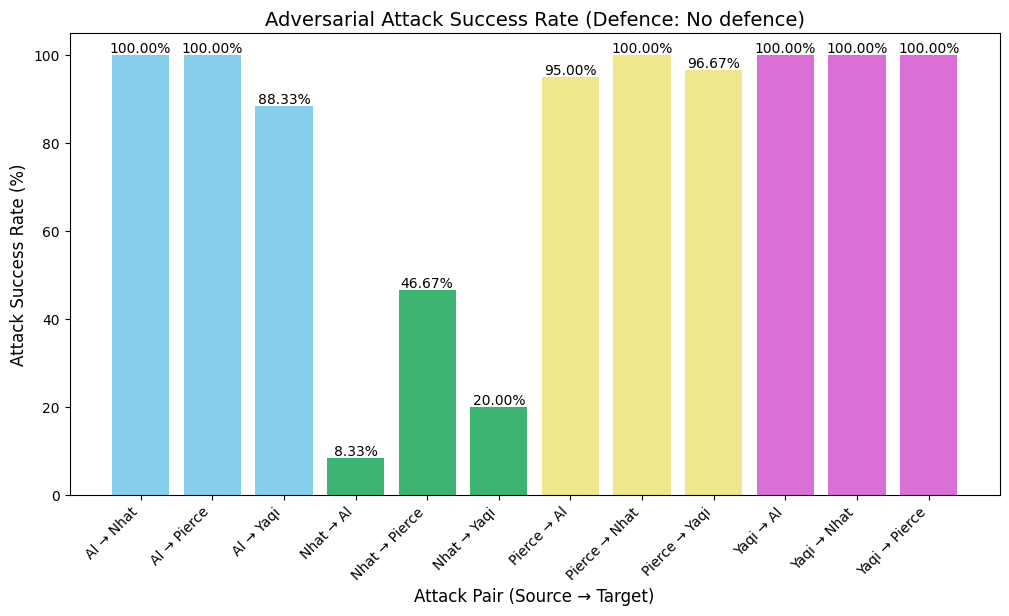

In [7]:
plot_bar_chart(results)

## Evaluate Defences

In [ ]:
# Function to evaluate an attack model
def evaluate_attack_with_defence(source_person, target_person, defence, epsilon=0.05):
    """
    Evaluates a trained attack model on validation images.
    
    Args:
        source_person (str): Name of the person to attack.
        target_person (str): Name of the person to impersonate.
        epsilon (float): Maximum perturbation magnitude.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data transforms - same as training
    transform = T.Compose([
        T.Resize((160, 160)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Load class mapping
    class_labels = ["Al", "Nhat", "Pierce", "Yaqi"]
    source_idx = class_labels.index(source_person)
    target_idx = class_labels.index(target_person)

    print(f"Evaluating attack: {source_person}({source_idx}) → {target_person}({target_idx})")

    # Create dataset focused on source person
    test_dir = 'data/test'  # Use validation images
    dataset = FaceAttackDataset(
        root_dir=test_dir, 
        source_idx=source_idx,
        target_idx=target_idx,
        transform=transform
    )

    if len(dataset) == 0:
        print(f"Error: No samples found for person {source_person}")
        return False

    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

    # Load the victim face recognition model
    face_model = InceptionResnetV1(
        classify=True,
        pretrained=None,
        num_classes=len(class_labels)
    ).to(device)
    
    face_model.load_state_dict(torch.load("facenet_4class.pth", map_location=device))
    face_model.eval()  # Set to evaluation mode

    # Load trained attack model
    attack_model = UNetAttackGenerator().to(device)
    attack_model.load_state_dict(torch.load(f"attack_{source_person}_to_{target_person}.pth", map_location=device))
    attack_model.eval()

    # Evaluation loop
    total_samples = 0
    attack_success = 0

    with torch.no_grad():
        for images, orig_labels, target_labels in dataloader:
            images = images.to(device)
            orig_labels = orig_labels.to(device)
            target_labels = target_labels.to(device)

            # Generate perturbation and adversarial images
            perturbation = attack_model(images)
            adv_images = torch.clamp(images + perturbation, -1, 1)

            # Apply defence
            adv_images = defence(adv_images)

            # Get predictions
            clean_outputs = face_model(images)
            adv_outputs = face_model(adv_images)

            clean_preds = torch.argmax(clean_outputs, dim=1)
            adv_preds = torch.argmax(adv_outputs, dim=1)

            # Compute attack success
            success = (adv_preds == target_labels).float().sum().item()
            attack_success += success
            total_samples += images.size(0)

    success_rate = attack_success / total_samples * 100
    print(f"Attack Success Rate: {success_rate:.2f}%")

    return success_rate

### Evaluate Randomization Defence

In [33]:
class_labels = ["Al", "Nhat", "Pierce", "Yaqi"]
attack_pairs = [(src, tgt) for src in class_labels for tgt in class_labels if src != tgt]

results_randomization = {}

for source_person, target_person in attack_pairs:
    print(f"\n{'='*60}")
    print(f"Evaluating RANDOMIZATION defence: {source_person} → {target_person}")
    print(f"{'='*60}")
    
    success_rate = evaluate_attack_with_defence(source_person, target_person, Randomization())
    results_randomization[f"{source_person} → {target_person}"] = success_rate

print("\nFinal Results:")
for attack, success_rate in results_randomization.items():
    print(f"{attack}: {success_rate:.2f}%")


Evaluating RANDOMIZATION defence: Al → Nhat
Using device: cuda
Evaluating attack: Al(0) → Nhat(1)
Attack Success Rate: 80.00%

Evaluating RANDOMIZATION defence: Al → Pierce
Using device: cuda
Evaluating attack: Al(0) → Pierce(2)
Attack Success Rate: 58.33%

Evaluating RANDOMIZATION defence: Al → Yaqi
Using device: cuda
Evaluating attack: Al(0) → Yaqi(3)
Attack Success Rate: 11.67%

Evaluating RANDOMIZATION defence: Nhat → Al
Using device: cuda
Evaluating attack: Nhat(1) → Al(0)
Attack Success Rate: 0.00%

Evaluating RANDOMIZATION defence: Nhat → Pierce
Using device: cuda
Evaluating attack: Nhat(1) → Pierce(2)
Attack Success Rate: 11.67%

Evaluating RANDOMIZATION defence: Nhat → Yaqi
Using device: cuda
Evaluating attack: Nhat(1) → Yaqi(3)
Attack Success Rate: 13.33%

Evaluating RANDOMIZATION defence: Pierce → Al
Using device: cuda
Evaluating attack: Pierce(2) → Al(0)
Attack Success Rate: 40.00%

Evaluating RANDOMIZATION defence: Pierce → Nhat
Using device: cuda
Evaluating attack: Pierc

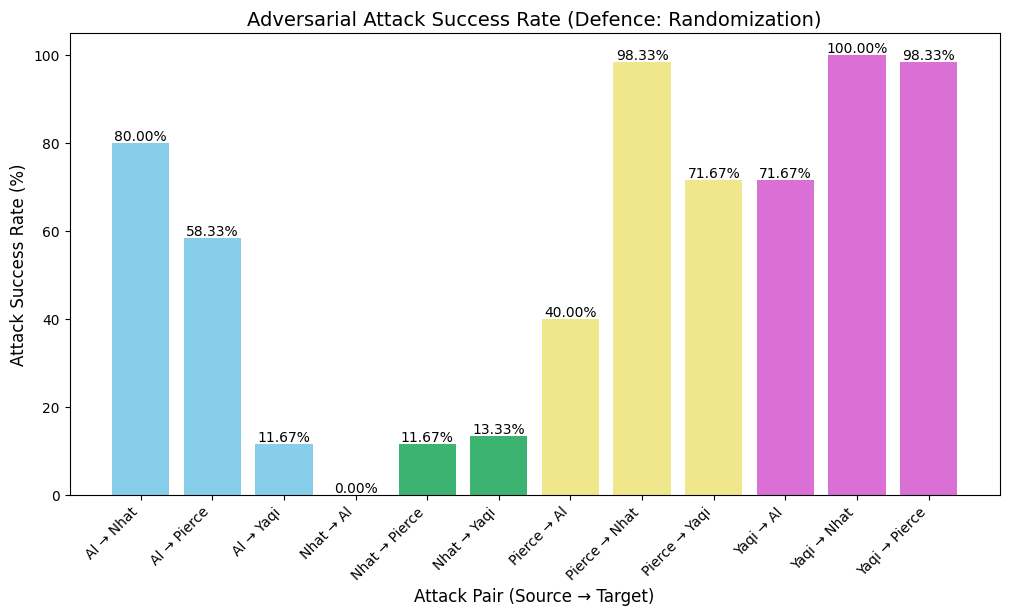

In [39]:
plot_bar_chart(results_randomization, "Randomization")

### Evaluate Jpeg Compression Defence

In [40]:
results_jpeg = {}

for source_person, target_person in attack_pairs:
    print(f"\n{'='*60}")
    print(f"Evaluating JPEG COMPRESSION defence: {source_person} → {target_person}")
    print(f"{'='*60}")
    
    success_rate = evaluate_attack_with_defence(source_person, target_person, Jpeg_compression())
    results_jpeg[f"{source_person} → {target_person}"] = success_rate

print("\nFinal Results:")
for attack, success_rate in results_jpeg.items():
    print(f"{attack}: {success_rate:.2f}%")


Evaluating JPEG COMPRESSION defence: Al → Nhat
Using device: cuda
Evaluating attack: Al(0) → Nhat(1)
Attack Success Rate: 98.33%

Evaluating JPEG COMPRESSION defence: Al → Pierce
Using device: cuda
Evaluating attack: Al(0) → Pierce(2)
Attack Success Rate: 86.67%

Evaluating JPEG COMPRESSION defence: Al → Yaqi
Using device: cuda
Evaluating attack: Al(0) → Yaqi(3)
Attack Success Rate: 0.00%

Evaluating JPEG COMPRESSION defence: Nhat → Al
Using device: cuda
Evaluating attack: Nhat(1) → Al(0)
Attack Success Rate: 63.33%

Evaluating JPEG COMPRESSION defence: Nhat → Pierce
Using device: cuda
Evaluating attack: Nhat(1) → Pierce(2)
Attack Success Rate: 0.00%

Evaluating JPEG COMPRESSION defence: Nhat → Yaqi
Using device: cuda
Evaluating attack: Nhat(1) → Yaqi(3)
Attack Success Rate: 0.00%

Evaluating JPEG COMPRESSION defence: Pierce → Al
Using device: cuda
Evaluating attack: Pierce(2) → Al(0)
Attack Success Rate: 5.00%

Evaluating JPEG COMPRESSION defence: Pierce → Nhat
Using device: cuda
Eva

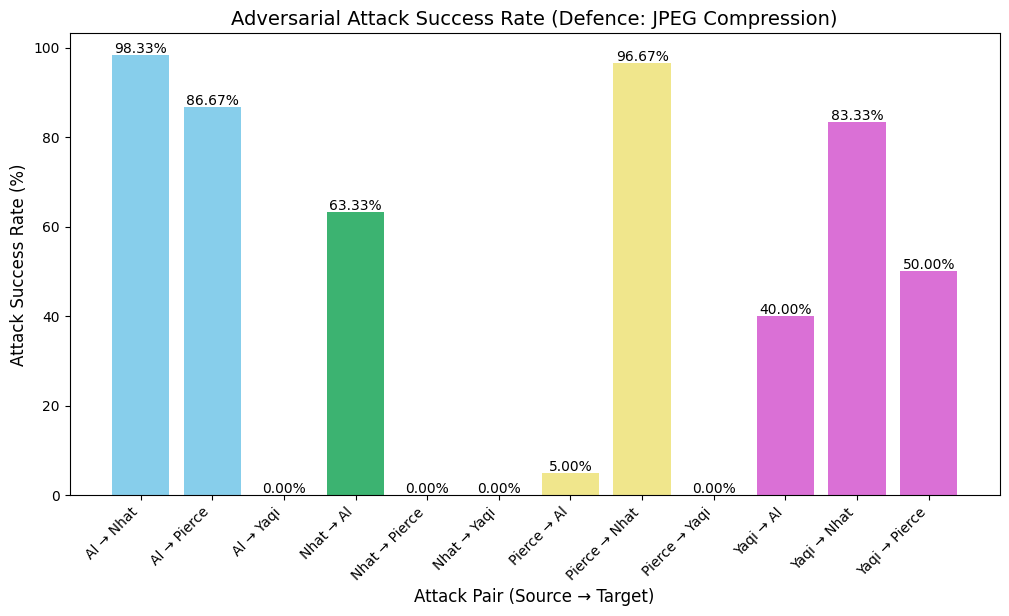

In [41]:
plot_bar_chart(results_jpeg, "JPEG Compression")

### Evaluate Bit Depth Reduction Defence

In [42]:
results_bit_depth = {}

for source_person, target_person in attack_pairs:
    print(f"\n{'='*60}")
    print(f"Evaluating BIT DEPTH REDUCTION defence: {source_person} → {target_person}")
    print(f"{'='*60}")
    
    success_rate = evaluate_attack_with_defence(source_person, target_person, BitDepthReduction())
    results_bit_depth[f"{source_person} → {target_person}"] = success_rate

print("\nFinal Results:")
for attack, success_rate in results_bit_depth.items():
    print(f"{attack}: {success_rate:.2f}%")


Evaluating BIT DEPTH REDUCTION defence: Al → Nhat
Using device: cuda
Evaluating attack: Al(0) → Nhat(1)
Attack Success Rate: 100.00%

Evaluating BIT DEPTH REDUCTION defence: Al → Pierce
Using device: cuda
Evaluating attack: Al(0) → Pierce(2)
Attack Success Rate: 88.33%

Evaluating BIT DEPTH REDUCTION defence: Al → Yaqi
Using device: cuda
Evaluating attack: Al(0) → Yaqi(3)
Attack Success Rate: 73.33%

Evaluating BIT DEPTH REDUCTION defence: Nhat → Al
Using device: cuda
Evaluating attack: Nhat(1) → Al(0)
Attack Success Rate: 0.00%

Evaluating BIT DEPTH REDUCTION defence: Nhat → Pierce
Using device: cuda
Evaluating attack: Nhat(1) → Pierce(2)
Attack Success Rate: 33.33%

Evaluating BIT DEPTH REDUCTION defence: Nhat → Yaqi
Using device: cuda
Evaluating attack: Nhat(1) → Yaqi(3)
Attack Success Rate: 11.67%

Evaluating BIT DEPTH REDUCTION defence: Pierce → Al
Using device: cuda
Evaluating attack: Pierce(2) → Al(0)
Attack Success Rate: 88.33%

Evaluating BIT DEPTH REDUCTION defence: Pierce →

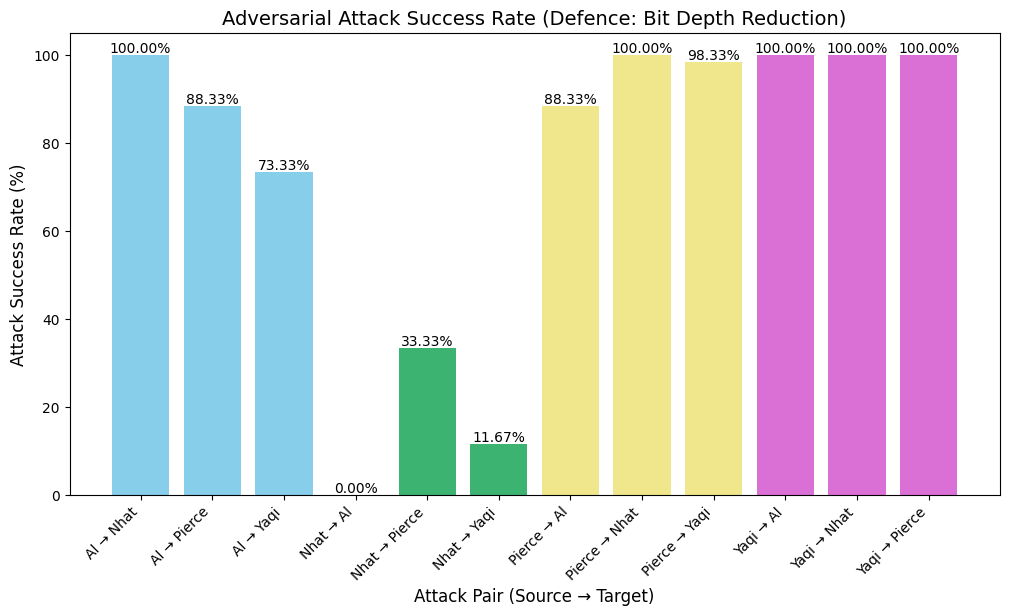

In [43]:
plot_bar_chart(results_bit_depth, "Bit Depth Reduction")